In [284]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# LOAD MNIST dataset from tensorflow package

In [285]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [286]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 48 * dec_in_channels / 2

def leaky_relu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [287]:
# VAE Class with CNN implementation for encoder and decoder
# inspired by https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

def encoder(X_in, keep_prob):
    activation = leaky_relu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=32, kernel_size=3, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=leaky_relu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=leaky_relu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [288]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

unreshaped = tf.reshape(dec, [-1, 28*28])
# image reconstruction loss
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
# KL divergence loss
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Save model every 10,000 steps
saver = tf.train.Saver()
saver.save(sess, './vae_mnist_model', global_step=10000, write_meta_graph=False)
# Create a write to record data for tensorboard visualization
writer = tf.summary.FileWriter('./vae_mnist_tensorboard', sess.graph)

iteration: 0, overall_loss: 178.4798583984375, recon_loss: 178.47000122070312, kl_loss: 0.009867310523986816


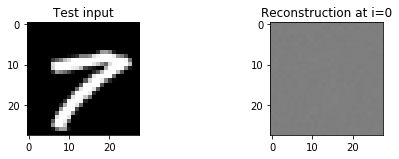

iteration: 100, overall_loss: 53.80332946777344, recon_loss: 53.62799835205078, kl_loss: 0.1753329336643219
iteration: 200, overall_loss: 48.638282775878906, recon_loss: 47.825042724609375, kl_loss: 0.8132425546646118
iteration: 300, overall_loss: 46.58475112915039, recon_loss: 44.22747039794922, kl_loss: 2.3572804927825928
iteration: 400, overall_loss: 42.13001251220703, recon_loss: 36.755287170410156, kl_loss: 5.37472677230835
iteration: 500, overall_loss: 40.913299560546875, recon_loss: 35.37481689453125, kl_loss: 5.538481712341309


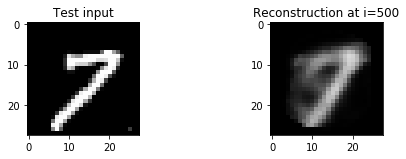

iteration: 600, overall_loss: 36.929595947265625, recon_loss: 30.507022857666016, kl_loss: 6.42257022857666
iteration: 700, overall_loss: 37.75741195678711, recon_loss: 30.7236385345459, kl_loss: 7.03377103805542
iteration: 800, overall_loss: 36.89801788330078, recon_loss: 29.661577224731445, kl_loss: 7.236441612243652
iteration: 900, overall_loss: 35.793582916259766, recon_loss: 27.892915725708008, kl_loss: 7.900667667388916
iteration: 1000, overall_loss: 32.33021545410156, recon_loss: 24.59491539001465, kl_loss: 7.735301971435547


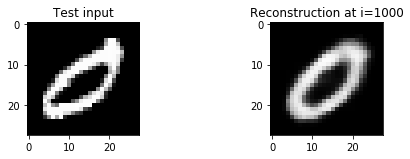

iteration: 1100, overall_loss: 33.51314926147461, recon_loss: 25.895158767700195, kl_loss: 7.617990493774414
iteration: 1200, overall_loss: 36.68888854980469, recon_loss: 28.990957260131836, kl_loss: 7.697930335998535
iteration: 1300, overall_loss: 34.357948303222656, recon_loss: 26.721221923828125, kl_loss: 7.6367268562316895
iteration: 1400, overall_loss: 33.79222106933594, recon_loss: 25.382278442382812, kl_loss: 8.409942626953125
iteration: 1500, overall_loss: 35.00651168823242, recon_loss: 26.339210510253906, kl_loss: 8.667299270629883


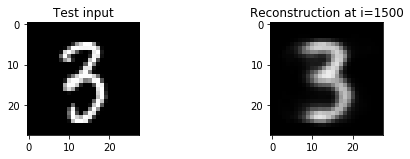

iteration: 1600, overall_loss: 32.664947509765625, recon_loss: 24.422353744506836, kl_loss: 8.242593765258789
iteration: 1700, overall_loss: 32.54434585571289, recon_loss: 24.34450340270996, kl_loss: 8.19984245300293
iteration: 1800, overall_loss: 33.44388961791992, recon_loss: 24.972434997558594, kl_loss: 8.471452713012695
iteration: 1900, overall_loss: 33.9011116027832, recon_loss: 25.272151947021484, kl_loss: 8.628959655761719
iteration: 2000, overall_loss: 32.557960510253906, recon_loss: 24.651721954345703, kl_loss: 7.906239032745361


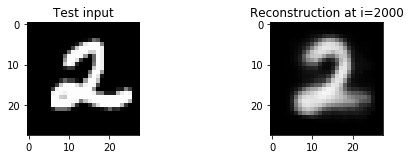

iteration: 2100, overall_loss: 32.997276306152344, recon_loss: 24.67593002319336, kl_loss: 8.321346282958984
iteration: 2200, overall_loss: 33.08911895751953, recon_loss: 23.84765625, kl_loss: 9.241458892822266
iteration: 2300, overall_loss: 36.028968811035156, recon_loss: 27.562557220458984, kl_loss: 8.466415405273438
iteration: 2400, overall_loss: 35.430912017822266, recon_loss: 26.27463150024414, kl_loss: 9.156279563903809
iteration: 2500, overall_loss: 31.648351669311523, recon_loss: 23.459131240844727, kl_loss: 8.189220428466797


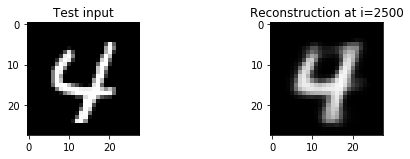

iteration: 2600, overall_loss: 31.399200439453125, recon_loss: 22.557289123535156, kl_loss: 8.84190845489502
iteration: 2700, overall_loss: 31.223575592041016, recon_loss: 22.978961944580078, kl_loss: 8.244612693786621
iteration: 2800, overall_loss: 32.38693618774414, recon_loss: 23.87120246887207, kl_loss: 8.515734672546387
iteration: 2900, overall_loss: 30.872007369995117, recon_loss: 21.704750061035156, kl_loss: 9.167257308959961
iteration: 3000, overall_loss: 30.287899017333984, recon_loss: 21.127201080322266, kl_loss: 9.160696983337402


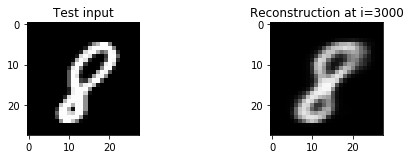

iteration: 3100, overall_loss: 29.19809913635254, recon_loss: 19.860490798950195, kl_loss: 9.337608337402344
iteration: 3200, overall_loss: 33.247589111328125, recon_loss: 24.495777130126953, kl_loss: 8.751809120178223
iteration: 3300, overall_loss: 30.863780975341797, recon_loss: 21.801177978515625, kl_loss: 9.062602996826172
iteration: 3400, overall_loss: 31.250120162963867, recon_loss: 21.975788116455078, kl_loss: 9.274334907531738
iteration: 3500, overall_loss: 31.774944305419922, recon_loss: 22.570178985595703, kl_loss: 9.204763412475586


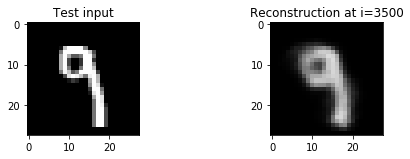

iteration: 3600, overall_loss: 33.25984191894531, recon_loss: 24.010456085205078, kl_loss: 9.249383926391602
iteration: 3700, overall_loss: 33.552127838134766, recon_loss: 24.390743255615234, kl_loss: 9.161385536193848
iteration: 3800, overall_loss: 32.04280090332031, recon_loss: 23.160802841186523, kl_loss: 8.881998062133789
iteration: 3900, overall_loss: 31.944459915161133, recon_loss: 22.903667449951172, kl_loss: 9.040793418884277
iteration: 4000, overall_loss: 30.677608489990234, recon_loss: 21.917526245117188, kl_loss: 8.760082244873047


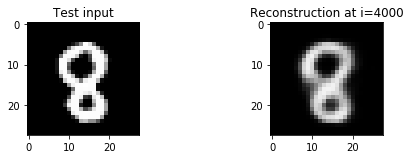

iteration: 4100, overall_loss: 31.064434051513672, recon_loss: 21.98686408996582, kl_loss: 9.077569961547852
iteration: 4200, overall_loss: 31.917648315429688, recon_loss: 22.67485809326172, kl_loss: 9.242788314819336
iteration: 4300, overall_loss: 29.990699768066406, recon_loss: 20.484275817871094, kl_loss: 9.50642204284668
iteration: 4400, overall_loss: 31.758941650390625, recon_loss: 22.51703453063965, kl_loss: 9.241909980773926
iteration: 4500, overall_loss: 30.780590057373047, recon_loss: 21.42945671081543, kl_loss: 9.35113525390625


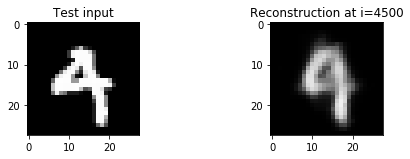

iteration: 4600, overall_loss: 32.13163375854492, recon_loss: 22.59147834777832, kl_loss: 9.540153503417969
iteration: 4700, overall_loss: 29.26358985900879, recon_loss: 19.261478424072266, kl_loss: 10.002111434936523
iteration: 4800, overall_loss: 29.70274543762207, recon_loss: 20.54033660888672, kl_loss: 9.162406921386719
iteration: 4900, overall_loss: 31.85215950012207, recon_loss: 22.619178771972656, kl_loss: 9.232982635498047
iteration: 5000, overall_loss: 31.377235412597656, recon_loss: 21.76213836669922, kl_loss: 9.615097045898438


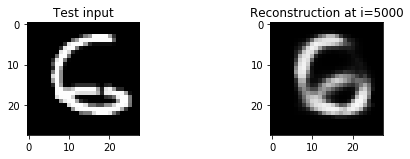

iteration: 5100, overall_loss: 30.216222763061523, recon_loss: 21.288753509521484, kl_loss: 8.927469253540039
iteration: 5200, overall_loss: 31.3992919921875, recon_loss: 21.50841522216797, kl_loss: 9.890875816345215
iteration: 5300, overall_loss: 30.966506958007812, recon_loss: 21.285480499267578, kl_loss: 9.681024551391602
iteration: 5400, overall_loss: 30.145069122314453, recon_loss: 20.993432998657227, kl_loss: 9.151636123657227
iteration: 5500, overall_loss: 28.998859405517578, recon_loss: 19.290191650390625, kl_loss: 9.708667755126953


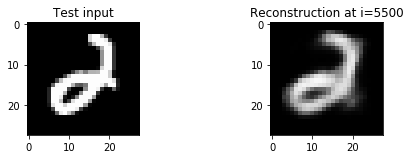

iteration: 5600, overall_loss: 30.386199951171875, recon_loss: 20.994457244873047, kl_loss: 9.391745567321777
iteration: 5700, overall_loss: 31.361141204833984, recon_loss: 21.796871185302734, kl_loss: 9.564270973205566
iteration: 5800, overall_loss: 30.90775489807129, recon_loss: 21.842361450195312, kl_loss: 9.06539249420166
iteration: 5900, overall_loss: 30.311805725097656, recon_loss: 21.073455810546875, kl_loss: 9.238348960876465
iteration: 6000, overall_loss: 30.13434600830078, recon_loss: 20.624515533447266, kl_loss: 9.509828567504883


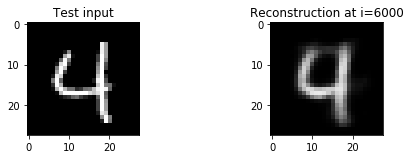

iteration: 6100, overall_loss: 30.29669189453125, recon_loss: 20.763235092163086, kl_loss: 9.533454895019531
iteration: 6200, overall_loss: 30.475730895996094, recon_loss: 20.56020164489746, kl_loss: 9.915529251098633
iteration: 6300, overall_loss: 29.548934936523438, recon_loss: 20.48583221435547, kl_loss: 9.063104629516602
iteration: 6400, overall_loss: 28.750789642333984, recon_loss: 18.92828369140625, kl_loss: 9.822504043579102
iteration: 6500, overall_loss: 29.647079467773438, recon_loss: 20.069904327392578, kl_loss: 9.57717514038086


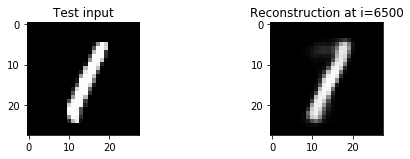

iteration: 6600, overall_loss: 31.980405807495117, recon_loss: 22.466014862060547, kl_loss: 9.51439094543457
iteration: 6700, overall_loss: 30.924297332763672, recon_loss: 21.01285171508789, kl_loss: 9.911444664001465
iteration: 6800, overall_loss: 30.516387939453125, recon_loss: 20.862932205200195, kl_loss: 9.653458595275879
iteration: 6900, overall_loss: 30.846797943115234, recon_loss: 21.150785446166992, kl_loss: 9.696012496948242
iteration: 7000, overall_loss: 28.119264602661133, recon_loss: 18.889606475830078, kl_loss: 9.229658126831055


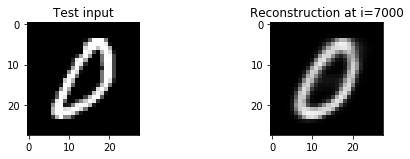

iteration: 7100, overall_loss: 28.816923141479492, recon_loss: 19.218395233154297, kl_loss: 9.598527908325195
iteration: 7200, overall_loss: 27.721038818359375, recon_loss: 18.43869400024414, kl_loss: 9.282344818115234
iteration: 7300, overall_loss: 30.125350952148438, recon_loss: 20.269250869750977, kl_loss: 9.856100082397461
iteration: 7400, overall_loss: 30.464340209960938, recon_loss: 20.309982299804688, kl_loss: 10.154356002807617
iteration: 7500, overall_loss: 27.974815368652344, recon_loss: 18.211559295654297, kl_loss: 9.76325511932373


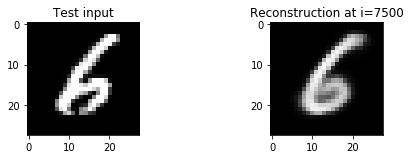

iteration: 7600, overall_loss: 30.270641326904297, recon_loss: 20.622238159179688, kl_loss: 9.64840316772461
iteration: 7700, overall_loss: 29.233509063720703, recon_loss: 19.27045249938965, kl_loss: 9.963057518005371
iteration: 7800, overall_loss: 31.257762908935547, recon_loss: 21.227275848388672, kl_loss: 10.030487060546875
iteration: 7900, overall_loss: 29.100841522216797, recon_loss: 19.16878318786621, kl_loss: 9.932058334350586
iteration: 8000, overall_loss: 30.387882232666016, recon_loss: 20.81356430053711, kl_loss: 9.574318885803223


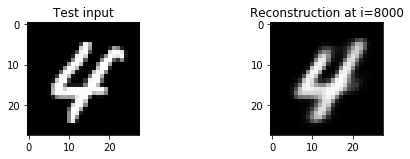

iteration: 8100, overall_loss: 30.673294067382812, recon_loss: 21.160778045654297, kl_loss: 9.512516021728516
iteration: 8200, overall_loss: 28.366857528686523, recon_loss: 19.186264038085938, kl_loss: 9.180593490600586
iteration: 8300, overall_loss: 31.246784210205078, recon_loss: 21.53206443786621, kl_loss: 9.714717864990234
iteration: 8400, overall_loss: 28.857463836669922, recon_loss: 19.537567138671875, kl_loss: 9.319893836975098
iteration: 8500, overall_loss: 30.88361930847168, recon_loss: 20.989280700683594, kl_loss: 9.89433765411377


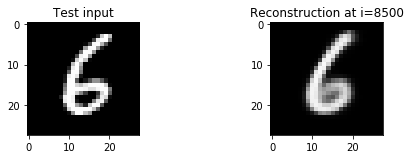

iteration: 8600, overall_loss: 29.454010009765625, recon_loss: 19.72370147705078, kl_loss: 9.730308532714844
iteration: 8700, overall_loss: 29.701457977294922, recon_loss: 19.580825805664062, kl_loss: 10.120635032653809
iteration: 8800, overall_loss: 28.301109313964844, recon_loss: 18.51970672607422, kl_loss: 9.781403541564941
iteration: 8900, overall_loss: 28.811614990234375, recon_loss: 19.10323715209961, kl_loss: 9.708378791809082
iteration: 9000, overall_loss: 28.40224266052246, recon_loss: 18.276172637939453, kl_loss: 10.126069068908691


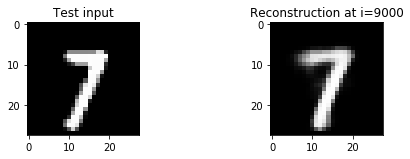

iteration: 9100, overall_loss: 29.24540138244629, recon_loss: 20.180686950683594, kl_loss: 9.064712524414062
iteration: 9200, overall_loss: 29.136201858520508, recon_loss: 19.244354248046875, kl_loss: 9.891845703125
iteration: 9300, overall_loss: 28.875635147094727, recon_loss: 19.05698585510254, kl_loss: 9.818649291992188
iteration: 9400, overall_loss: 29.04286766052246, recon_loss: 19.947511672973633, kl_loss: 9.095355987548828
iteration: 9500, overall_loss: 28.683975219726562, recon_loss: 18.576684951782227, kl_loss: 10.107288360595703


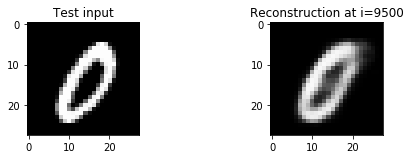

iteration: 9600, overall_loss: 30.146255493164062, recon_loss: 20.528663635253906, kl_loss: 9.617594718933105
iteration: 9700, overall_loss: 32.45336151123047, recon_loss: 22.918495178222656, kl_loss: 9.53486442565918
iteration: 9800, overall_loss: 28.52583122253418, recon_loss: 19.090877532958984, kl_loss: 9.434953689575195
iteration: 9900, overall_loss: 28.72390365600586, recon_loss: 18.459928512573242, kl_loss: 10.263973236083984
iteration: 10000, overall_loss: 29.633953094482422, recon_loss: 19.444358825683594, kl_loss: 10.189594268798828


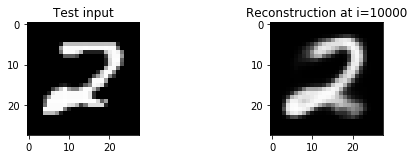

iteration: 10100, overall_loss: 29.29178237915039, recon_loss: 19.25680923461914, kl_loss: 10.034971237182617
iteration: 10200, overall_loss: 28.860645294189453, recon_loss: 18.956392288208008, kl_loss: 9.904252052307129
iteration: 10300, overall_loss: 30.76288604736328, recon_loss: 20.852216720581055, kl_loss: 9.91066837310791
iteration: 10400, overall_loss: 31.392311096191406, recon_loss: 21.010982513427734, kl_loss: 10.381330490112305
iteration: 10500, overall_loss: 28.683277130126953, recon_loss: 18.583709716796875, kl_loss: 10.099569320678711


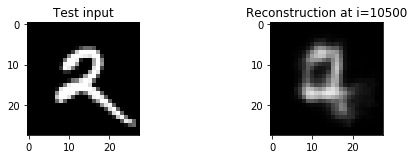

iteration: 10600, overall_loss: 31.680389404296875, recon_loss: 21.367816925048828, kl_loss: 10.312572479248047
iteration: 10700, overall_loss: 27.58255386352539, recon_loss: 18.127342224121094, kl_loss: 9.455211639404297
iteration: 10800, overall_loss: 31.171829223632812, recon_loss: 21.019908905029297, kl_loss: 10.151921272277832
iteration: 10900, overall_loss: 30.650218963623047, recon_loss: 20.61709213256836, kl_loss: 10.033126831054688
iteration: 11000, overall_loss: 29.969383239746094, recon_loss: 19.74544906616211, kl_loss: 10.223931312561035


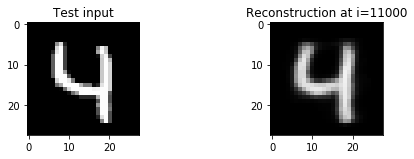

iteration: 11100, overall_loss: 29.59913444519043, recon_loss: 19.86835479736328, kl_loss: 9.730777740478516
iteration: 11200, overall_loss: 31.390125274658203, recon_loss: 21.50057601928711, kl_loss: 9.889549255371094
iteration: 11300, overall_loss: 28.778766632080078, recon_loss: 19.289531707763672, kl_loss: 9.489236831665039
iteration: 11400, overall_loss: 28.154823303222656, recon_loss: 18.60308074951172, kl_loss: 9.551740646362305
iteration: 11500, overall_loss: 28.40416717529297, recon_loss: 18.392105102539062, kl_loss: 10.01205825805664


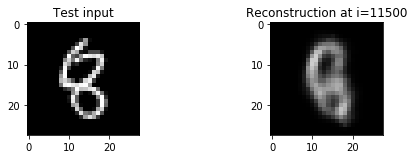

iteration: 11600, overall_loss: 27.75143814086914, recon_loss: 18.21074867248535, kl_loss: 9.540689468383789
iteration: 11700, overall_loss: 29.974197387695312, recon_loss: 20.16869354248047, kl_loss: 9.805502891540527
iteration: 11800, overall_loss: 27.886260986328125, recon_loss: 18.111970901489258, kl_loss: 9.77428913116455
iteration: 11900, overall_loss: 27.48758316040039, recon_loss: 17.51285171508789, kl_loss: 9.97473430633545
iteration: 12000, overall_loss: 29.114343643188477, recon_loss: 18.71975326538086, kl_loss: 10.39459228515625


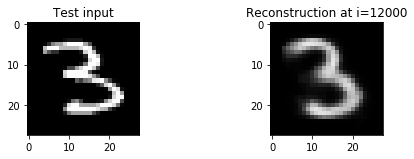

iteration: 12100, overall_loss: 28.98857879638672, recon_loss: 18.912738800048828, kl_loss: 10.075841903686523
iteration: 12200, overall_loss: 28.12431526184082, recon_loss: 17.731914520263672, kl_loss: 10.392400741577148
iteration: 12300, overall_loss: 28.902523040771484, recon_loss: 18.831008911132812, kl_loss: 10.071515083312988
iteration: 12400, overall_loss: 29.88565444946289, recon_loss: 19.61686897277832, kl_loss: 10.268787384033203
iteration: 12500, overall_loss: 28.603073120117188, recon_loss: 18.528303146362305, kl_loss: 10.07476806640625


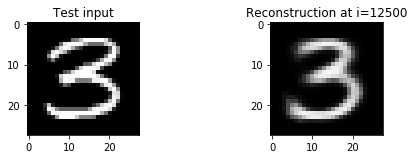

iteration: 12600, overall_loss: 28.123165130615234, recon_loss: 18.250743865966797, kl_loss: 9.87242317199707
iteration: 12700, overall_loss: 29.687326431274414, recon_loss: 19.44402503967285, kl_loss: 10.24329948425293
iteration: 12800, overall_loss: 31.20096778869629, recon_loss: 20.54912567138672, kl_loss: 10.65184211730957
iteration: 12900, overall_loss: 28.534685134887695, recon_loss: 19.029638290405273, kl_loss: 9.505046844482422
iteration: 13000, overall_loss: 27.430313110351562, recon_loss: 17.733049392700195, kl_loss: 9.697263717651367


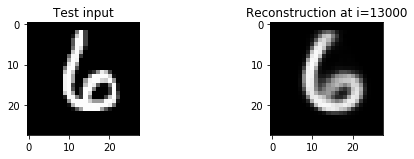

iteration: 13100, overall_loss: 29.202634811401367, recon_loss: 19.314659118652344, kl_loss: 9.887978553771973
iteration: 13200, overall_loss: 28.967981338500977, recon_loss: 18.933435440063477, kl_loss: 10.034546852111816
iteration: 13300, overall_loss: 28.213882446289062, recon_loss: 18.20828628540039, kl_loss: 10.005597114562988
iteration: 13400, overall_loss: 28.025571823120117, recon_loss: 17.834754943847656, kl_loss: 10.190815925598145
iteration: 13500, overall_loss: 29.929031372070312, recon_loss: 19.62310791015625, kl_loss: 10.305923461914062


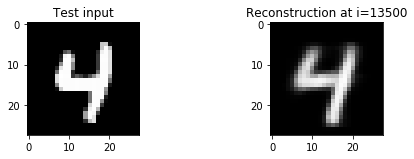

iteration: 13600, overall_loss: 28.58849334716797, recon_loss: 18.954601287841797, kl_loss: 9.633893966674805
iteration: 13700, overall_loss: 30.753684997558594, recon_loss: 20.588489532470703, kl_loss: 10.165196418762207
iteration: 13800, overall_loss: 29.441394805908203, recon_loss: 19.712677001953125, kl_loss: 9.728715896606445
iteration: 13900, overall_loss: 31.991683959960938, recon_loss: 21.926664352416992, kl_loss: 10.065019607543945
iteration: 14000, overall_loss: 29.89568519592285, recon_loss: 20.19570541381836, kl_loss: 9.699981689453125


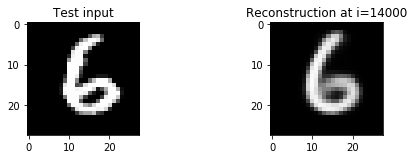

iteration: 14100, overall_loss: 29.550678253173828, recon_loss: 20.04324722290039, kl_loss: 9.507431030273438
iteration: 14200, overall_loss: 28.585670471191406, recon_loss: 18.218158721923828, kl_loss: 10.367511749267578
iteration: 14300, overall_loss: 29.619943618774414, recon_loss: 19.548412322998047, kl_loss: 10.071531295776367
iteration: 14400, overall_loss: 28.71593475341797, recon_loss: 18.684415817260742, kl_loss: 10.03152084350586
iteration: 14500, overall_loss: 29.974275588989258, recon_loss: 19.78318977355957, kl_loss: 10.191086769104004


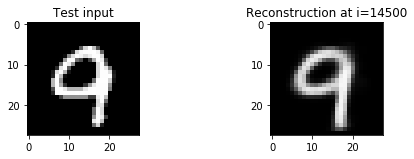

iteration: 14600, overall_loss: 29.666019439697266, recon_loss: 19.31708526611328, kl_loss: 10.348934173583984
iteration: 14700, overall_loss: 32.53517150878906, recon_loss: 22.223899841308594, kl_loss: 10.311269760131836
iteration: 14800, overall_loss: 27.847091674804688, recon_loss: 17.818538665771484, kl_loss: 10.028549194335938
iteration: 14900, overall_loss: 26.36193084716797, recon_loss: 16.655197143554688, kl_loss: 9.706733703613281
iteration: 15000, overall_loss: 30.502971649169922, recon_loss: 20.20354461669922, kl_loss: 10.299424171447754


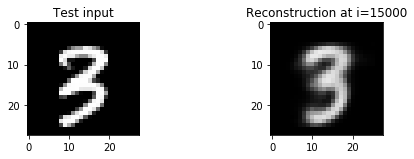

iteration: 15100, overall_loss: 28.0811710357666, recon_loss: 17.68794822692871, kl_loss: 10.393223762512207
iteration: 15200, overall_loss: 29.238506317138672, recon_loss: 19.241025924682617, kl_loss: 9.997480392456055
iteration: 15300, overall_loss: 28.01284408569336, recon_loss: 18.20334243774414, kl_loss: 9.809499740600586
iteration: 15400, overall_loss: 29.123811721801758, recon_loss: 18.786174774169922, kl_loss: 10.337636947631836
iteration: 15500, overall_loss: 29.93947982788086, recon_loss: 19.651010513305664, kl_loss: 10.28846549987793


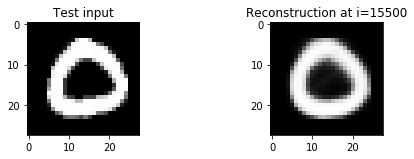

iteration: 15600, overall_loss: 28.335453033447266, recon_loss: 17.83200454711914, kl_loss: 10.503448486328125
iteration: 15700, overall_loss: 29.196121215820312, recon_loss: 19.16718101501465, kl_loss: 10.028938293457031
iteration: 15800, overall_loss: 30.32797622680664, recon_loss: 20.3924560546875, kl_loss: 9.935517311096191
iteration: 15900, overall_loss: 28.420635223388672, recon_loss: 17.77155876159668, kl_loss: 10.649076461791992
iteration: 16000, overall_loss: 30.70333480834961, recon_loss: 20.28612518310547, kl_loss: 10.417207717895508


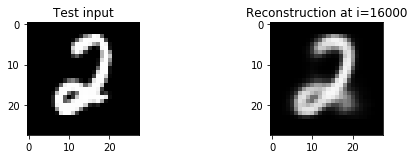

iteration: 16100, overall_loss: 28.132802963256836, recon_loss: 18.273040771484375, kl_loss: 9.859763145446777
iteration: 16200, overall_loss: 29.343725204467773, recon_loss: 19.152393341064453, kl_loss: 10.19133186340332
iteration: 16300, overall_loss: 29.113418579101562, recon_loss: 19.32830047607422, kl_loss: 9.785118103027344
iteration: 16400, overall_loss: 29.54848861694336, recon_loss: 19.660343170166016, kl_loss: 9.88814640045166
iteration: 16500, overall_loss: 28.90693473815918, recon_loss: 19.08428382873535, kl_loss: 9.822650909423828


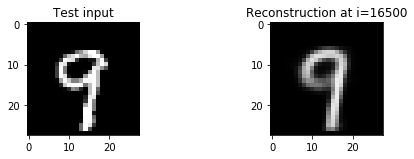

iteration: 16600, overall_loss: 29.410301208496094, recon_loss: 19.05884552001953, kl_loss: 10.351455688476562
iteration: 16700, overall_loss: 28.420154571533203, recon_loss: 18.964527130126953, kl_loss: 9.455626487731934
iteration: 16800, overall_loss: 28.056331634521484, recon_loss: 18.283634185791016, kl_loss: 9.772695541381836
iteration: 16900, overall_loss: 27.87369728088379, recon_loss: 18.0323543548584, kl_loss: 9.841344833374023
iteration: 17000, overall_loss: 30.4949951171875, recon_loss: 20.62146759033203, kl_loss: 9.873529434204102


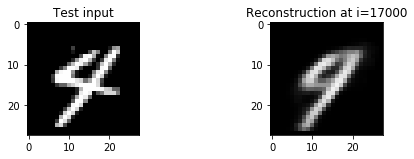

iteration: 17100, overall_loss: 27.958152770996094, recon_loss: 17.563335418701172, kl_loss: 10.394814491271973
iteration: 17200, overall_loss: 28.980979919433594, recon_loss: 19.100919723510742, kl_loss: 9.880061149597168
iteration: 17300, overall_loss: 29.64887046813965, recon_loss: 19.147674560546875, kl_loss: 10.501194953918457
iteration: 17400, overall_loss: 28.50670051574707, recon_loss: 18.312820434570312, kl_loss: 10.193880081176758
iteration: 17500, overall_loss: 27.360984802246094, recon_loss: 17.528343200683594, kl_loss: 9.832643508911133


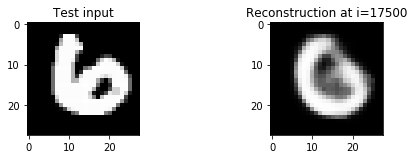

iteration: 17600, overall_loss: 28.066696166992188, recon_loss: 17.88237953186035, kl_loss: 10.184317588806152
iteration: 17700, overall_loss: 30.8017578125, recon_loss: 20.44751739501953, kl_loss: 10.354238510131836
iteration: 17800, overall_loss: 29.533130645751953, recon_loss: 19.44133949279785, kl_loss: 10.091793060302734
iteration: 17900, overall_loss: 28.857585906982422, recon_loss: 18.949962615966797, kl_loss: 9.90762710571289
iteration: 18000, overall_loss: 29.476947784423828, recon_loss: 18.908077239990234, kl_loss: 10.568870544433594


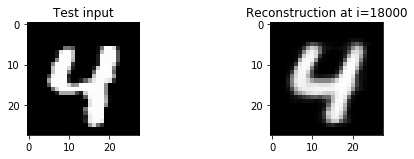

iteration: 18100, overall_loss: 26.564659118652344, recon_loss: 16.625267028808594, kl_loss: 9.93939208984375
iteration: 18200, overall_loss: 29.034591674804688, recon_loss: 18.869800567626953, kl_loss: 10.164793014526367
iteration: 18300, overall_loss: 27.066083908081055, recon_loss: 16.941822052001953, kl_loss: 10.124262809753418
iteration: 18400, overall_loss: 29.248905181884766, recon_loss: 19.027992248535156, kl_loss: 10.220914840698242
iteration: 18500, overall_loss: 28.952014923095703, recon_loss: 19.149948120117188, kl_loss: 9.802066802978516


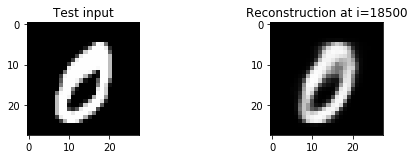

iteration: 18600, overall_loss: 26.888599395751953, recon_loss: 16.99591827392578, kl_loss: 9.892681121826172
iteration: 18700, overall_loss: 28.230941772460938, recon_loss: 18.203670501708984, kl_loss: 10.027271270751953
iteration: 18800, overall_loss: 27.989551544189453, recon_loss: 18.27894401550293, kl_loss: 9.71060562133789
iteration: 18900, overall_loss: 28.869384765625, recon_loss: 19.14838409423828, kl_loss: 9.721000671386719
iteration: 19000, overall_loss: 25.156837463378906, recon_loss: 15.276241302490234, kl_loss: 9.880596160888672


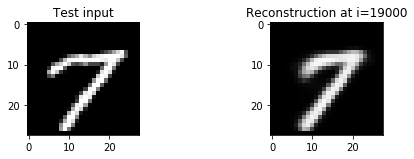

iteration: 19100, overall_loss: 29.192440032958984, recon_loss: 18.873424530029297, kl_loss: 10.319018363952637
iteration: 19200, overall_loss: 27.38459014892578, recon_loss: 16.985206604003906, kl_loss: 10.399382591247559
iteration: 19300, overall_loss: 25.913660049438477, recon_loss: 15.731428146362305, kl_loss: 10.182231903076172
iteration: 19400, overall_loss: 29.68439483642578, recon_loss: 19.813249588012695, kl_loss: 9.871146202087402
iteration: 19500, overall_loss: 28.041698455810547, recon_loss: 18.04043197631836, kl_loss: 10.00126838684082


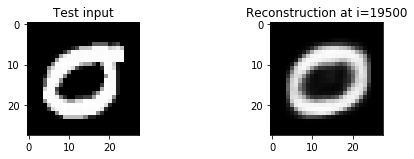

iteration: 19600, overall_loss: 28.998233795166016, recon_loss: 18.93730926513672, kl_loss: 10.060924530029297
iteration: 19700, overall_loss: 28.44064712524414, recon_loss: 17.722646713256836, kl_loss: 10.717998504638672
iteration: 19800, overall_loss: 27.648181915283203, recon_loss: 17.947986602783203, kl_loss: 9.700197219848633
iteration: 19900, overall_loss: 30.860244750976562, recon_loss: 21.1028995513916, kl_loss: 9.757345199584961
iteration: 20000, overall_loss: 28.223796844482422, recon_loss: 18.307994842529297, kl_loss: 9.915803909301758


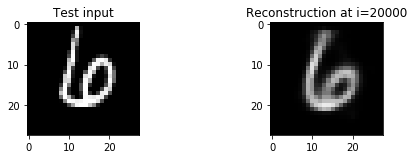

iteration: 20100, overall_loss: 26.876972198486328, recon_loss: 17.050006866455078, kl_loss: 9.826966285705566
iteration: 20200, overall_loss: 28.50438117980957, recon_loss: 18.756118774414062, kl_loss: 9.748263359069824
iteration: 20300, overall_loss: 31.260459899902344, recon_loss: 21.06317138671875, kl_loss: 10.197288513183594
iteration: 20400, overall_loss: 32.51385498046875, recon_loss: 22.148019790649414, kl_loss: 10.365837097167969
iteration: 20500, overall_loss: 29.725133895874023, recon_loss: 18.876184463500977, kl_loss: 10.84895133972168


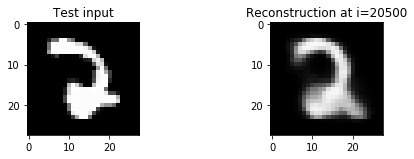

iteration: 20600, overall_loss: 28.437744140625, recon_loss: 18.556514739990234, kl_loss: 9.881229400634766
iteration: 20700, overall_loss: 28.939315795898438, recon_loss: 18.660356521606445, kl_loss: 10.278961181640625
iteration: 20800, overall_loss: 27.779300689697266, recon_loss: 17.972503662109375, kl_loss: 9.80679702758789
iteration: 20900, overall_loss: 29.747509002685547, recon_loss: 19.362852096557617, kl_loss: 10.38465404510498
iteration: 21000, overall_loss: 25.8323974609375, recon_loss: 16.344459533691406, kl_loss: 9.487936019897461


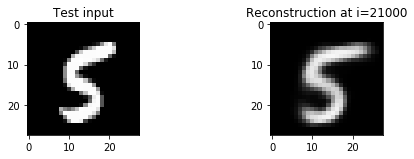

iteration: 21100, overall_loss: 26.447254180908203, recon_loss: 16.25753402709961, kl_loss: 10.189722061157227
iteration: 21200, overall_loss: 29.611988067626953, recon_loss: 19.505901336669922, kl_loss: 10.106084823608398
iteration: 21300, overall_loss: 30.438968658447266, recon_loss: 20.413494110107422, kl_loss: 10.025474548339844
iteration: 21400, overall_loss: 28.95147705078125, recon_loss: 18.703474044799805, kl_loss: 10.248004913330078
iteration: 21500, overall_loss: 28.136940002441406, recon_loss: 18.245283126831055, kl_loss: 9.891657829284668


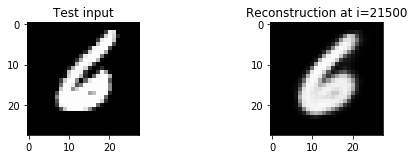

iteration: 21600, overall_loss: 28.118541717529297, recon_loss: 17.743654251098633, kl_loss: 10.374889373779297
iteration: 21700, overall_loss: 29.880252838134766, recon_loss: 19.14794921875, kl_loss: 10.732303619384766
iteration: 21800, overall_loss: 27.712188720703125, recon_loss: 17.32549285888672, kl_loss: 10.386697769165039
iteration: 21900, overall_loss: 27.997854232788086, recon_loss: 17.766071319580078, kl_loss: 10.231782913208008
iteration: 22000, overall_loss: 26.47432518005371, recon_loss: 16.153059005737305, kl_loss: 10.321266174316406


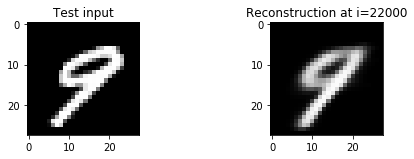

iteration: 22100, overall_loss: 28.535083770751953, recon_loss: 18.45207977294922, kl_loss: 10.08300495147705
iteration: 22200, overall_loss: 28.552509307861328, recon_loss: 18.433048248291016, kl_loss: 10.119464874267578
iteration: 22300, overall_loss: 27.320171356201172, recon_loss: 16.881004333496094, kl_loss: 10.439168930053711
iteration: 22400, overall_loss: 29.143817901611328, recon_loss: 18.65523910522461, kl_loss: 10.488580703735352
iteration: 22500, overall_loss: 27.347076416015625, recon_loss: 17.11154556274414, kl_loss: 10.2355318069458


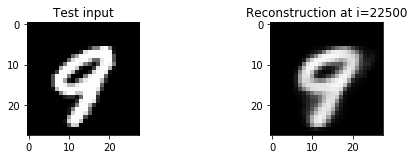

iteration: 22600, overall_loss: 28.325847625732422, recon_loss: 18.08617401123047, kl_loss: 10.239675521850586
iteration: 22700, overall_loss: 28.940040588378906, recon_loss: 18.569961547851562, kl_loss: 10.370079040527344
iteration: 22800, overall_loss: 28.785888671875, recon_loss: 18.560579299926758, kl_loss: 10.225309371948242
iteration: 22900, overall_loss: 28.476259231567383, recon_loss: 18.42041778564453, kl_loss: 10.055841445922852
iteration: 23000, overall_loss: 29.311214447021484, recon_loss: 18.936250686645508, kl_loss: 10.374964714050293


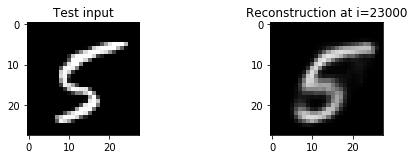

iteration: 23100, overall_loss: 29.811973571777344, recon_loss: 19.650901794433594, kl_loss: 10.161073684692383
iteration: 23200, overall_loss: 29.168601989746094, recon_loss: 19.636648178100586, kl_loss: 9.531954765319824
iteration: 23300, overall_loss: 29.161314010620117, recon_loss: 18.602012634277344, kl_loss: 10.559301376342773
iteration: 23400, overall_loss: 28.85971450805664, recon_loss: 18.88772201538086, kl_loss: 9.971991539001465
iteration: 23500, overall_loss: 30.09778594970703, recon_loss: 20.033987045288086, kl_loss: 10.063800811767578


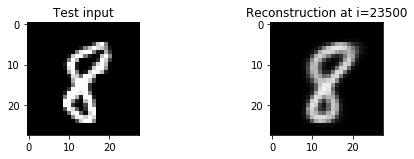

iteration: 23600, overall_loss: 28.29352569580078, recon_loss: 17.740985870361328, kl_loss: 10.55254077911377
iteration: 23700, overall_loss: 26.635051727294922, recon_loss: 16.504552841186523, kl_loss: 10.130497932434082
iteration: 23800, overall_loss: 27.264842987060547, recon_loss: 16.78189468383789, kl_loss: 10.482950210571289
iteration: 23900, overall_loss: 25.809497833251953, recon_loss: 16.21146011352539, kl_loss: 9.598038673400879
iteration: 24000, overall_loss: 27.84632110595703, recon_loss: 18.086719512939453, kl_loss: 9.759600639343262


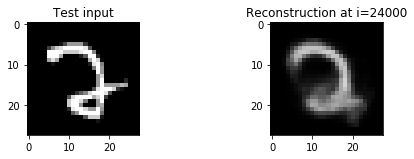

iteration: 24100, overall_loss: 28.564653396606445, recon_loss: 18.604679107666016, kl_loss: 9.959976196289062
iteration: 24200, overall_loss: 26.896404266357422, recon_loss: 16.893985748291016, kl_loss: 10.002418518066406
iteration: 24300, overall_loss: 28.264301300048828, recon_loss: 18.421884536743164, kl_loss: 9.842414855957031
iteration: 24400, overall_loss: 28.216156005859375, recon_loss: 18.180347442626953, kl_loss: 10.035807609558105
iteration: 24500, overall_loss: 28.957172393798828, recon_loss: 18.808917999267578, kl_loss: 10.14825439453125


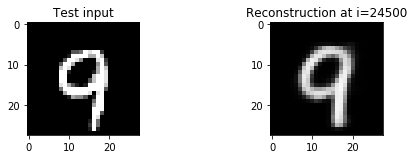

iteration: 24600, overall_loss: 29.881534576416016, recon_loss: 19.52375030517578, kl_loss: 10.357786178588867
iteration: 24700, overall_loss: 26.034042358398438, recon_loss: 16.049842834472656, kl_loss: 9.984199523925781
iteration: 24800, overall_loss: 27.39947509765625, recon_loss: 17.594879150390625, kl_loss: 9.804596900939941
iteration: 24900, overall_loss: 26.43327522277832, recon_loss: 16.47935676574707, kl_loss: 9.95391845703125
iteration: 25000, overall_loss: 29.242748260498047, recon_loss: 19.147212982177734, kl_loss: 10.095537185668945


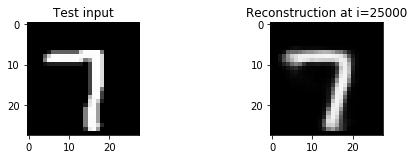

iteration: 25100, overall_loss: 28.896480560302734, recon_loss: 18.894254684448242, kl_loss: 10.002225875854492
iteration: 25200, overall_loss: 27.641128540039062, recon_loss: 17.674381256103516, kl_loss: 9.966745376586914
iteration: 25300, overall_loss: 26.734294891357422, recon_loss: 16.799213409423828, kl_loss: 9.935083389282227
iteration: 25400, overall_loss: 30.08749008178711, recon_loss: 19.969572067260742, kl_loss: 10.117918014526367
iteration: 25500, overall_loss: 26.073246002197266, recon_loss: 16.05032730102539, kl_loss: 10.022920608520508


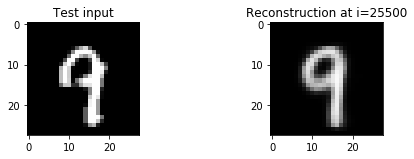

iteration: 25600, overall_loss: 27.287700653076172, recon_loss: 17.1787052154541, kl_loss: 10.10899543762207
iteration: 25700, overall_loss: 27.666540145874023, recon_loss: 17.47723388671875, kl_loss: 10.189306259155273
iteration: 25800, overall_loss: 28.09853744506836, recon_loss: 17.468460083007812, kl_loss: 10.630077362060547
iteration: 25900, overall_loss: 29.144445419311523, recon_loss: 18.74249839782715, kl_loss: 10.401945114135742
iteration: 26000, overall_loss: 27.255186080932617, recon_loss: 17.798656463623047, kl_loss: 9.456531524658203


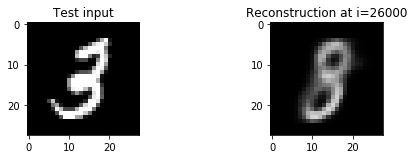

iteration: 26100, overall_loss: 27.59084701538086, recon_loss: 17.1490478515625, kl_loss: 10.441798210144043
iteration: 26200, overall_loss: 27.58420753479004, recon_loss: 17.43295669555664, kl_loss: 10.151253700256348
iteration: 26300, overall_loss: 28.850154876708984, recon_loss: 18.704633712768555, kl_loss: 10.145520210266113
iteration: 26400, overall_loss: 29.905670166015625, recon_loss: 19.545486450195312, kl_loss: 10.360185623168945
iteration: 26500, overall_loss: 27.03183364868164, recon_loss: 16.73250961303711, kl_loss: 10.299322128295898


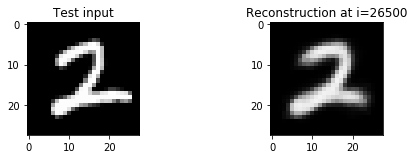

iteration: 26600, overall_loss: 27.44642448425293, recon_loss: 17.42856216430664, kl_loss: 10.017860412597656
iteration: 26700, overall_loss: 28.011394500732422, recon_loss: 17.289596557617188, kl_loss: 10.721797943115234
iteration: 26800, overall_loss: 28.82602310180664, recon_loss: 18.589733123779297, kl_loss: 10.236288070678711
iteration: 26900, overall_loss: 27.71691131591797, recon_loss: 17.704357147216797, kl_loss: 10.012556076049805
iteration: 27000, overall_loss: 29.54417610168457, recon_loss: 18.969085693359375, kl_loss: 10.575090408325195


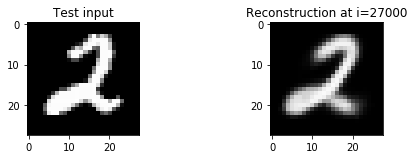

iteration: 27100, overall_loss: 28.787307739257812, recon_loss: 18.06670570373535, kl_loss: 10.720602035522461
iteration: 27200, overall_loss: 28.824739456176758, recon_loss: 18.946449279785156, kl_loss: 9.878287315368652
iteration: 27300, overall_loss: 30.431907653808594, recon_loss: 20.35668182373047, kl_loss: 10.075225830078125
iteration: 27400, overall_loss: 28.685222625732422, recon_loss: 18.297504425048828, kl_loss: 10.387716293334961
iteration: 27500, overall_loss: 28.80181884765625, recon_loss: 18.78740692138672, kl_loss: 10.014411926269531


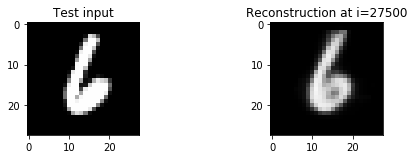

iteration: 27600, overall_loss: 28.51186752319336, recon_loss: 18.20657730102539, kl_loss: 10.305290222167969
iteration: 27700, overall_loss: 27.36084747314453, recon_loss: 17.52225112915039, kl_loss: 9.83859634399414
iteration: 27800, overall_loss: 28.661483764648438, recon_loss: 18.167930603027344, kl_loss: 10.493553161621094
iteration: 27900, overall_loss: 27.07039451599121, recon_loss: 16.83983612060547, kl_loss: 10.230560302734375
iteration: 28000, overall_loss: 30.049449920654297, recon_loss: 19.655048370361328, kl_loss: 10.394400596618652


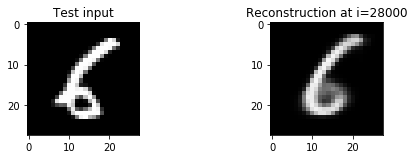

iteration: 28100, overall_loss: 28.88333511352539, recon_loss: 18.658267974853516, kl_loss: 10.225067138671875
iteration: 28200, overall_loss: 26.18922233581543, recon_loss: 16.519672393798828, kl_loss: 9.669549942016602
iteration: 28300, overall_loss: 28.72386932373047, recon_loss: 18.38298225402832, kl_loss: 10.340887069702148
iteration: 28400, overall_loss: 27.08057403564453, recon_loss: 16.716567993164062, kl_loss: 10.364006042480469
iteration: 28500, overall_loss: 28.552997589111328, recon_loss: 18.162757873535156, kl_loss: 10.390237808227539


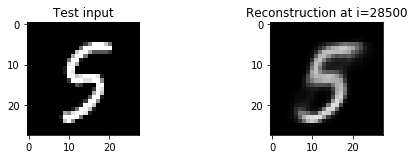

iteration: 28600, overall_loss: 28.903385162353516, recon_loss: 18.703516006469727, kl_loss: 10.199867248535156
iteration: 28700, overall_loss: 28.917179107666016, recon_loss: 19.03463363647461, kl_loss: 9.882545471191406
iteration: 28800, overall_loss: 29.429981231689453, recon_loss: 18.997488021850586, kl_loss: 10.4324951171875
iteration: 28900, overall_loss: 28.52285385131836, recon_loss: 18.497997283935547, kl_loss: 10.024856567382812
iteration: 29000, overall_loss: 27.798534393310547, recon_loss: 17.84190559387207, kl_loss: 9.956628799438477


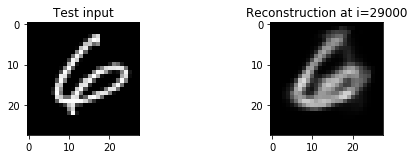

iteration: 29100, overall_loss: 28.168869018554688, recon_loss: 18.093952178955078, kl_loss: 10.07491397857666
iteration: 29200, overall_loss: 28.180377960205078, recon_loss: 17.681175231933594, kl_loss: 10.499201774597168
iteration: 29300, overall_loss: 26.148914337158203, recon_loss: 16.197843551635742, kl_loss: 9.951069831848145
iteration: 29400, overall_loss: 27.899715423583984, recon_loss: 17.816667556762695, kl_loss: 10.083047866821289
iteration: 29500, overall_loss: 28.588855743408203, recon_loss: 18.572235107421875, kl_loss: 10.016620635986328


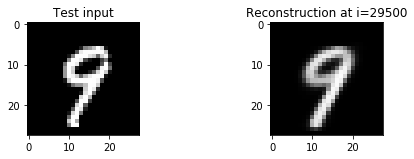

iteration: 29600, overall_loss: 29.356840133666992, recon_loss: 18.71719741821289, kl_loss: 10.639642715454102
iteration: 29700, overall_loss: 29.118900299072266, recon_loss: 18.701675415039062, kl_loss: 10.417227745056152
iteration: 29800, overall_loss: 28.32391357421875, recon_loss: 18.23611068725586, kl_loss: 10.087803840637207
iteration: 29900, overall_loss: 27.590116500854492, recon_loss: 17.28227424621582, kl_loss: 10.307842254638672


In [ ]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    
    if not i % 100:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        print("iteration: {}, overall_loss: {}, recon_loss: {}, kl_loss: {}".format(
            i, ls, np.mean(i_ls), np.mean(d_ls)))
    if not i % 500:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.figure(figsize=(8, 12))
        plt.subplot(5, 2, 2 + 1)
        plt.imshow(np.reshape(batch[0], [28, 28]), vmin=0, vmax=1, cmap="gray")
        plt.title("Test input")
        plt.subplot(5, 2, 2 + 2)
        plt.imshow(d[0], vmin=0, vmax=1, cmap="gray")
        plt.title("Reconstruction at i={}".format(i))
        plt.show()

write.close()

# Randomly generate some images from normal distribution

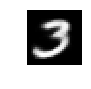

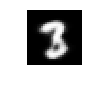

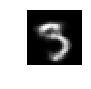

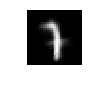

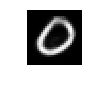

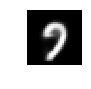

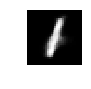

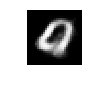

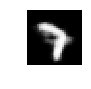

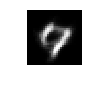

In [253]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')